In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# https://datahack.analyticsvidhya.com/contest/mckinsey-analytics-online-hackathon-4/#

## TODO: implement bootstrapping for getting coefficient error bars --> random forest is already doing that!
## TODO: implement proper data transformation pipelining  --> Done!
## TODO: normalize/scale inputs to allow for use of regularization  --> can be skipped in case of xgboost random forest
## TODO: implement gridsearch to get best hyperparameters

file = "train_ZoGVYWq.csv"
data = pd.read_csv(file)


### Pre-prep data (type and name adjustments only, data independent)

In [2]:
def pre_prep(df):
    data = df.copy()
    data.set_index('id', inplace=True)
    data['sourcing_channel'] = data['sourcing_channel'].astype('category') 
    data['residence_area_type'] = data['residence_area_type'].astype('category')
    new_names = {'perc_premium_paid_by_cash_credit': 'cash_credit',
                'Count_3-6_months_late': 'late3',
                'Count_6-12_months_late': 'late6',
                'Count_more_than_12_months_late': 'late12',
                'application_underwriting_score': 'score',
                'residence_area_type': 'residence',
                'no_of_premiums_paid': 'prems_paid',
                'sourcing_channel': 'channel'}
    data.rename(index=str, columns=new_names, inplace=True)
    return data

data['renewal'] = data['renewal'].astype('bool')
data_pre_prepped = pre_prep(data)

### Numerical/Visual inspection
Full visual inspection: see other notebook for plots, etc

In [3]:
data_pre_prepped.T

id,110936,41492,31300,19415,99379,59951,54031,94290,93730,84844,...,84628,11262,25366,104705,91081,48057,59012,77050,67225,71531
cash_credit,0.429,0.01,0.917,0.049,0.052,0.54,1,1,0.621,0.908,...,0.454,0.994,0.825,0.118,0.033,0.425,0.704,0,0.398,0.55
age_in_days,12058,21546,17531,15341,31400,17527,24829,21911,9868,23008,...,25928,20445,14979,22275,18265,23367,19356,23372,22641,15709
Income,355060,315150,84140,250510,198680,282080,118400,180240,92520,107180,...,70800,186830,360060,195070,301540,224550,279150,305020,39330,280140
late3,0,0,2,0,0,2,0,1,0,2,...,0,0,2,0,0,1,1,0,0,1
late6,0,0,3,0,0,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
late12,0,0,1,0,0,0,0,4,0,0,...,0,0,0,0,0,0,1,0,0,1
score,99.02,99.89,98.69,99.57,99.87,99.18,99.05,99.33,99.58,98.91,...,98.19,99.67,98.61,99.25,99.89,98.7,99.42,98.89,98.68,99.84
prems_paid,13,21,7,9,12,9,11,3,4,11,...,7,5,10,11,4,19,12,12,8,8
channel,C,A,C,A,B,B,B,A,A,A,...,A,A,D,A,A,B,A,A,A,A
residence,Urban,Urban,Rural,Urban,Urban,Rural,Urban,Urban,Urban,Rural,...,Urban,Urban,Urban,Urban,Rural,Urban,Rural,Rural,Rural,Urban


In [4]:
data_pre_prepped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79853 entries, 110936 to 71531
Data columns (total 12 columns):
cash_credit    79853 non-null float64
age_in_days    79853 non-null int64
Income         79853 non-null int64
late3          79756 non-null float64
late6          79756 non-null float64
late12         79756 non-null float64
score          76879 non-null float64
prems_paid     79853 non-null int64
channel        79853 non-null category
residence      79853 non-null category
premium        79853 non-null int64
renewal        79853 non-null bool
dtypes: bool(1), category(2), float64(5), int64(4)
memory usage: 8.8+ MB


In [5]:
data_pre_prepped.describe()

,cash_credit,age_in_days,Income,late3,late6,late12,score,prems_paid,premium
count,79853.000000,79853.000000,7.985300e+04,79756.000000,79756.000000,79756.000000,76879.000000,79853.000000,79853.000000
mean,0.314288,18846.696906,2.088472e+05,0.248671,0.078188,0.060008,99.067291,10.863887,10924.507533
std,0.334915,5208.719136,4.965826e+05,0.691468,0.436507,0.312023,0.739799,5.170687,9401.676542
min,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,91.900000,2.000000,1200.000000
25%,0.034000,14974.000000,1.080100e+05,0.000000,0.000000,0.000000,98.810000,7.000000,5400.000000
50%,0.167000,18625.000000,1.665600e+05,0.000000,0.000000,0.000000,99.210000,10.000000,7500.000000
75%,0.538000,22636.000000,2.520900e+05,0.000000,0.000000,0.000000,99.540000,14.000000,13800.000000
max,1.000000,37602.000000,9.026260e+07,13.000000,17.000000,11.000000,99.890000,60.000000,60000.000000


# Split sets

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_pre_prepped.drop('renewal', axis=1), 
                                                    data_pre_prepped['renewal'], 
                                                    test_size=0.20, 
                                                    random_state=42)

# train_test_split(data_pre_prepped, data_pre_prepped['renewal'], test_size=0.20, random_state=42)
len(X_train)

63882

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63882 entries, 56158 to 99690
Data columns (total 11 columns):
cash_credit    63882 non-null float64
age_in_days    63882 non-null int64
Income         63882 non-null int64
late3          63801 non-null float64
late6          63801 non-null float64
late12         63801 non-null float64
score          61534 non-null float64
prems_paid     63882 non-null int64
channel        63882 non-null category
residence      63882 non-null category
premium        63882 non-null int64
dtypes: category(2), float64(5), int64(4)
memory usage: 5.0+ MB


 # Creating the transformation pipeline 

In [8]:
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.feature_extraction import DictVectorizer
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from dftrans import DFFeatureUnion, DFImputer, ColumnExtractor, Log1pTransformer, DummyTransformer, DFFunctionTransformer

### Dummy transformation pipelines

In [9]:
# channel categorical: dummy transformation #TODO: remove redundant column
pip_channel = Pipeline([('extract_channel', ColumnExtractor(['channel'])),
                        ('get_channel_dummies', DummyTransformer())
                       ])

# residence categorical: dummy transformation #TODO: remove redundant column
pip_residence = Pipeline([('extract_residence', ColumnExtractor(['residence'])),
                          ('get_residence_dummies', DummyTransformer())
                         ])



### Numerical transformation pipeline

In [10]:
# Numerical pipeline: components:
pip_score = Pipeline([('select_score', ColumnExtractor(['score'])),
                      ('imp_score', DFImputer(strategy='mean')),
                      ('exp_stretch', DFFunctionTransformer(lambda x: np.exp(x/100)))
                     ])

pip_late_counts = Pipeline([('select_late_counts', ColumnExtractor(['late3', 'late6', 'late12'])),
                            ('imp_late_counts', DFImputer(strategy='most_frequent'))
                           ])

pip_logtrans_income = Pipeline([('select_income', ColumnExtractor(['Income'])),
                                ('logtrans_income', Log1pTransformer())
                               ])

pip_others = Pipeline([('extractor', ColumnExtractor(['cash_credit', 'age_in_days', 'prems_paid', 'premium']))
                      ])

# construct numericals pipeline
pip_numericals = DFFeatureUnion([('pip_score', pip_score),
                      ('pip_late_counts', pip_late_counts),
                      ('pip_logtrans_income', pip_logtrans_income),
                      ('others', pip_others)])


### Combining all pipelines

In [11]:
pip = DFFeatureUnion([('pip_channel', pip_channel),
                      ('pip_numericals', pip_numericals),
                      ('pip_residence', pip_residence)
                     ])

In [12]:
# from sklearn.cross_validation import Bootstrap
# b = Bootstrap(6, n_bootstraps=3, n_train=1.0, random_state=42)

In [13]:


X_train_trans = pip.fit_transform(X_train)
X_train_trans.head()

,channel=A,channel=B,channel=C,channel=D,channel=E,score,late3,late6,late12,Income,cash_credit,age_in_days,prems_paid,premium,residence=Rural,residence=Urban
id,,,,,,,,,,,,,,,,
56158,0.0,0.0,0.0,0.0,1.0,2.699590,0.0,0.0,0.0,12.397812,0.527,14248,8,1200,1.0,0.0
83192,0.0,1.0,0.0,0.0,0.0,2.697971,0.0,0.0,0.0,12.222886,0.901,18265,8,9600,0.0,1.0
22201,1.0,0.0,0.0,0.0,0.0,2.694196,0.0,0.0,0.0,11.431075,0.262,28844,10,5400,0.0,1.0
104286,0.0,0.0,0.0,1.0,0.0,2.687201,1.0,0.0,0.0,11.832259,0.868,22642,17,11700,0.0,1.0
43583,1.0,0.0,0.0,0.0,0.0,2.703372,0.0,0.0,0.0,12.425333,0.186,18625,8,20100,1.0,0.0


## Define AUC ROC curve plot function

In [14]:
#X_train.to_csv("train_imputed_encoded.csv")
#X_train.describe()

def plot_curve(fpr, tpr, roc_auc, title):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    # return plt



# Train Model

In [19]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


In [20]:
m = XGBClassifier(eval_metric='auc', objective='binary:logistic')
# m = LogisticRegression()

In [23]:
# XGBoost with grid search

params={
    'max_depth': [2,4,6,8], # 5 is good but takes too long in kaggle env
    'subsample': [0.4,0.6,0.8,1.0],
    'colsample_bytree': [0.5,0.6,0.8],
    'n_estimators': [1000,2000,3000],
    'reg_alpha': [0.01, 0.02, 0.04]
}


rs = GridSearchCV(m,
                  params,
                  cv=2,
                  scoring="roc_auc",
                  n_jobs=3,
                  verbose=2)
rs.fit(X_train_trans, y_train)
best_est = rs.best_estimator_
print(best_est)


ValueError: k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=1.

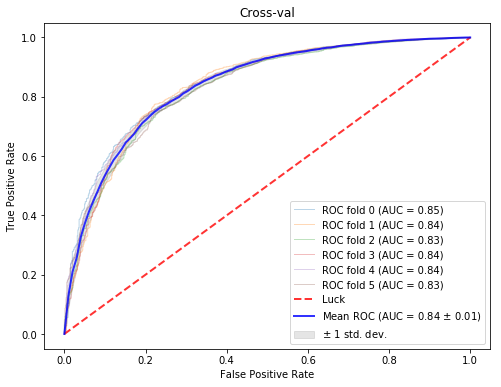

In [69]:
## Cross Eval
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
cv = StratifiedKFold(n_splits=6)  # bootstrapping equivalent
figsize=(8, 6)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
plt.figure(figsize=(8, 6))
for train, test in cv.split(X_train_trans, y_train):
    probas_ = m.fit(X_train_trans.iloc[train], y_train.iloc[train]).predict_proba(X_train_trans.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-val')
plt.legend(loc="lower right")
plt.show()

Bootstrapping does not add significant value, the curve is stable for 6 random subsets. The reason for this is that the random forest itself already employs a form of bootstrapping among its trees. 

In [38]:
m.fit(X=X_train_trans, y=y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [39]:
X_train_trans.head()

,channel=A,channel=B,channel=C,channel=D,channel=E,score,late3,late6,late12,Income,cash_credit,age_in_days,prems_paid,premium,residence=Rural,residence=Urban
id,,,,,,,,,,,,,,,,
56158,0.0,0.0,0.0,0.0,1.0,2.699590,0.0,0.0,0.0,12.397812,0.527,14248,8,1200,1.0,0.0
83192,0.0,1.0,0.0,0.0,0.0,2.697971,0.0,0.0,0.0,12.222886,0.901,18265,8,9600,0.0,1.0
22201,1.0,0.0,0.0,0.0,0.0,2.694196,0.0,0.0,0.0,11.431075,0.262,28844,10,5400,0.0,1.0
104286,0.0,0.0,0.0,1.0,0.0,2.687201,1.0,0.0,0.0,11.832259,0.868,22642,17,11700,0.0,1.0
43583,1.0,0.0,0.0,0.0,0.0,2.703372,0.0,0.0,0.0,12.425333,0.186,18625,8,20100,1.0,0.0


### Analyze train data predicitions

In [40]:
from sklearn.metrics import classification_report
from sklearn import metrics

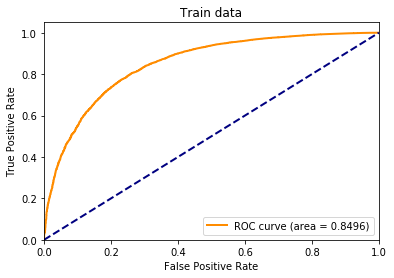

In [41]:
y_train_pred = m.predict_proba(X_train_trans)[:,1]
fpr_tr, tpr_tr, thresholds_tr = metrics.roc_curve(y_train , y_train_pred, pos_label=True)
roc_auc_tr = metrics.roc_auc_score(y_train, y_train_pred)
plot_curve(fpr_tr, tpr_tr, roc_auc_tr, 'Train data')

# Make predictions on test data

In [42]:
X_test_trans = pip.transform(X_test)
y_proba = m.predict_proba(X_test_trans)[:,1]

### Analysis

In [43]:
print(classification_report(y_true=y_test, y_pred=y_proba>.9))

             precision    recall  f1-score   support

      False       0.26      0.63      0.37      1032
       True       0.97      0.88      0.92     14939

avg / total       0.93      0.86      0.89     15971



In [44]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba, pos_label=True)
roc_auc = metrics.roc_auc_score(y_test, y_proba)

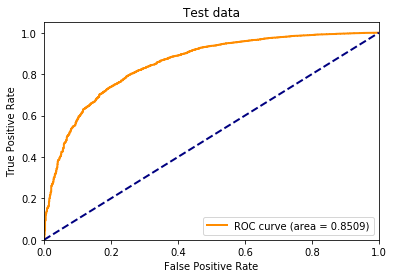

In [45]:
plot_curve(fpr, tpr, roc_auc, 'Test data')

AUC ROC score looks good! Test data score is higher then train data score, which means we did not overfit!

# Using validated model real on test data

In [22]:
data_test = pd.read_csv("test_66516Ee.csv")

data_pre_prepped_test = pre_prep(data_test)

test = pip.transform(data_pre_prepped_test)

In [23]:
test.head()

,channel=A,channel=B,channel=C,channel=D,channel=E,score,late3,late6,late12,Income,cash_credit,age_in_days,prems_paid,premium,residence=Rural,residence=Urban
id,,,,,,,,,,,,,,,,
649,1.0,0.0,0.0,0.0,0.0,2.715293,0.0,0.0,0.0,10.842537,0.001,27384,7,3300,1.0,0.0
81136,1.0,0.0,0.0,0.0,0.0,2.689351,0.0,0.0,0.0,12.560739,0.124,23735,19,11700,0.0,1.0
70762,0.0,1.0,0.0,0.0,0.0,2.693077,0.0,0.0,0.0,12.133669,1.000,17170,2,11700,0.0,1.0
53935,0.0,1.0,0.0,0.0,0.0,2.691234,0.0,0.0,0.0,11.724328,0.198,16068,11,5400,1.0,0.0
15476,1.0,0.0,0.0,0.0,0.0,2.695813,1.0,0.0,0.0,12.206178,0.041,10591,14,9600,1.0,0.0


In [24]:
X_test_trans.head()

,channel=A,channel=B,channel=C,channel=D,channel=E,score,late3,late6,late12,Income,cash_credit,age_in_days,prems_paid,premium,residence=Rural,residence=Urban
id,,,,,,,,,,,,,,,,
67251,0.0,0.0,0.0,1.0,0.0,2.687469,0.0,0.0,0.0,12.104101,0.125,16797,15,13800,0.0,1.0
86418,0.0,1.0,0.0,0.0,0.0,2.696353,0.0,0.0,0.0,12.032380,0.021,23375,20,7500,0.0,1.0
101134,1.0,0.0,0.0,0.0,0.0,2.674600,0.0,0.0,0.0,11.538116,0.033,21908,7,7500,0.0,1.0
55058,0.0,0.0,1.0,0.0,0.0,2.698780,0.0,0.0,0.0,12.507809,0.147,13510,7,24300,0.0,1.0
2632,1.0,0.0,0.0,0.0,0.0,2.712579,0.0,0.0,0.0,10.842146,1.000,10965,3,3300,0.0,1.0


In [25]:
y_proba = m.predict_proba(test)[:,1]

In [26]:
out = pd.DataFrame({'id': data_pre_prepped_test.index, 'renewal': y_proba, 'incentives': 200 * np.ones(len(y_proba))})
out.head()

,id,renewal,incentives
0,649,0.991843,200.0
1,81136,0.985018,200.0
2,70762,0.827242,200.0
3,53935,0.973506,200.0
4,15476,0.959751,200.0


In [27]:
out.to_csv('pred.csv', index=False)